In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from keras import layers
from tensorflow.keras import callbacks

# Read in cleaned data

In [42]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [43]:
df = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

# Group Dataframe by date and LOR

In [44]:
df.head()

,Unnamed: 0,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,BZR,PGR,Bezirk
0,0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,7100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0,71001,710,7
1,1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,2100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0,21001,210,2
2,2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,8300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0,83009,830,8
3,3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,4400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0,44007,440,4
4,4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,9100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0,91003,910,9


In [45]:
# Group dataframe by date and LOR
df_theft_model = df.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft_model.fillna(value = 0, inplace=True)

In [46]:
df_theft_model

Bezirk,1,2,3,4,5,6,7,8,9,10,11,12
date_theft_start,,,,,,,,,,,,
2021-01-01,1.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0
2021-01-02,0.0,0.0,5.0,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0
2021-01-03,1.0,1.0,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0
2021-01-04,6.0,7.0,3.0,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0
2021-01-05,7.0,2.0,2.0,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,3.0,10.0,14.0,3.0,0.0,4.0,7.0,4.0,5.0,0.0,1.0,1.0
2022-02-25,3.0,6.0,6.0,5.0,2.0,3.0,5.0,1.0,5.0,3.0,2.0,1.0
2022-02-26,4.0,2.0,3.0,1.0,1.0,3.0,4.0,2.0,0.0,0.0,1.0,0.0


In [47]:
# create "total" column which sums up data for each day
df_theft_model["total"] = df_theft_model.sum(axis=1)

df_theft_model.shape

(424, 13)

In [48]:
df_theft_model.head()

Bezirk,1,2,3,4,5,6,7,8,9,10,11,12,total
date_theft_start,,,,,,,,,,,,,
2021-01-01,1.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,16.0
2021-01-02,0.0,0.0,5.0,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,16.0
2021-01-03,1.0,1.0,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,17.0
2021-01-04,6.0,7.0,3.0,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0,33.0
2021-01-05,7.0,2.0,2.0,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0,29.0


In [37]:
df_theft_model["total"]

date_theft_start
2021-01-01    16.0
2021-01-02    16.0
2021-01-03    17.0
2021-01-04    33.0
2021-01-05    29.0
              ... 
2022-02-23    32.0
2022-02-24    27.0
2022-02-25    27.0
2022-02-26    12.0
2022-02-27     5.0
Name: total, Length: 423, dtype: float64

In [49]:
pd.date_range(start = df["date_theft_start"].min(), end = df["date_theft_start"].max()).difference(df_theft_model.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

# Build a baseline model predicting total of stolen bikes

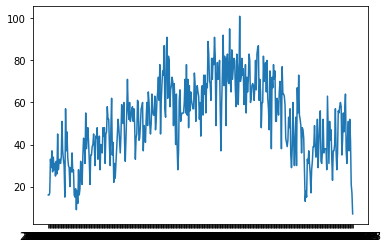

In [54]:
plt.plot(df_theft_model["total"]);

## Train-Test-Split

In [77]:
len(df_theft_model)

424

In [80]:
len_ = int(len(df_theft_model)*0.8)
len_

339

In [81]:
df_train = df_theft_model["total"][:len_]

In [82]:
df_test = df_theft_model["total"][len_:]

In [83]:
df_test.head()

date_theft_start
2021-12-06    38.0
2021-12-07    60.0
2021-12-08    42.0
2021-12-09    30.0
2021-12-10    43.0
Name: total, dtype: float64

In [84]:
df_train

date_theft_start
2021-01-01    16.0
2021-01-02    16.0
2021-01-03    17.0
2021-01-04    33.0
2021-01-05    29.0
              ... 
2021-12-01    53.0
2021-12-02    48.0
2021-12-03    57.0
2021-12-04    35.0
2021-12-05    29.0
Name: total, Length: 339, dtype: float64

## Baseline model

As a baseline model we just predict the mean of the train set. 

In [97]:
y_pred_base = [df_train.mean()] * len(df_test)

In [105]:
mean_squared_error(df_test, y_pred_base, squared = False)
# 

18.892062626042613

## Build a RNN model

In [125]:
window_size = 7
future_horizon = 2

def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset[i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [129]:
X_train, y_train = get_X_y(7,1, df_train)

In [132]:
X_train.shape

(331, 7)

In [141]:
X_train = np.expand_dims(X_train, 2)

In [143]:
X_train.shape[1:]

(7, 1)

In [144]:
rnn_model = Sequential()
rnn_model.add(LSTM(units=10, activation='tanh', input_shape = X_train.shape[1:]))
rnn_model.add(Dense(1, activation="linear"))

In [145]:
rnn_model.compile(loss = "mse", 
                 optimizer = "rmsprop", 
                 metrics = RootMeanSquaredError())

In [147]:
es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = rnn_model.fit(X_train, 
                        y_train,
          batch_size=8, 
          epochs=50,
          validation_split=0.2,
          callbacks=[es], verbose = 1)

Epoch 1/50
33/33 [==============================] - 1s 5ms/step - loss: 3038.7742 - root_mean_squared_error: 55.1251 - val_loss: 4123.1470 - val_root_mean_squared_error: 64.2117
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 3017.0183 - root_mean_squared_error: 54.9274 - val_loss: 4091.6362 - val_root_mean_squared_error: 63.9659
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 2977.2534 - root_mean_squared_error: 54.5642 - val_loss: 4033.4478 - val_root_mean_squared_error: 63.5094
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 2943.0134 - root_mean_squared_error: 54.2495 - val_loss: 4003.1255 - val_root_mean_squared_error: 63.2703
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 2921.5945 - root_mean_squared_error: 54.0518 - val_loss: 3980.7546 - val_root_mean_squared_error: 63.0932
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 2902.9609 - root_mean_squared_error: 5

In [ ]:
rnn_model

In [35]:
df_theft_model.shape

(423, 539)

In [ ]:
df["date_theft_start"].min(), df["date_theft_start"].max()